In [ ]:
# Copyright 2024 Gary Ng github.com/gkcng
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
# This notebook adapted the transformer code from https://www.tensorflow.org/text/tutorials/transformer

# Environment

In [1]:
try:
  from google.colab import drive
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
  drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd "/content/drive/My Drive/Colab Notebooks/arc_transformer/"

/content/drive/My Drive/Colab Notebooks/arc_transformer


In [3]:
gpu_info = !nvidia-smi 2> /dev/null || echo "failed"
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory

ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Fri Mar  8 10:43:31 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import time
import re
import pickle

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import gridspec

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from scipy.spatial.transform import Rotation

In [5]:
print(tf.__version__)

2.15.0


# Loading Data

In [6]:
!pwd

/content/drive/My Drive/Colab Notebooks/arc_transformer


In [7]:
# Set some parameters
FG=5 # Feature grid size

im_width  = 5
im_height = 5

# train_dir="tgs-salt-identification-challenge/competition_data/train"
# data_file="data/arc_v6_gsb.npz"
# data_file="data/arc_v7_rotated_gsb.npz"
# data_file="data/arc_v8_rotated_gsb_tasks.npz"
# data_file="data/moveapixelxone-5x5_tasks.npz"
data_file="data/moveapixelxone-5x5-multicolor_tasks.npz"

In [8]:
# @title
data_dict = np.load(data_file, allow_pickle=True)

data   = data_dict["x_train"] # max 32 x 32 grids

names = data_dict["y_train"] # <task_id>_<dataset>_<example_num>_<inputoutpu> id string
attrs  = data_dict["a_train"] # Metadaa about the task
print(data.shape)

test_data   = data_dict["x_test"] # max 32 x 32 grids
test_names = data_dict["y_test"] # <task_id>_<dataset>_<example_num>_<inputoutpu> id string
test_attrs  = data_dict["a_test"] # Metadaa about the task
print(test_data.shape)

print("No. of grids = ", len(data))
print("Data shape", data.shape)

(4728, 2, 2, 5, 5, 3)
(1052, 2, 2, 5, 5, 3)
No. of grids =  4728
Data shape (4728, 2, 2, 5, 5, 3)


# Data Utiliies

## Padding Utils

In [16]:
# Pad a ARC Task grid for uniformity
def pad_grid(grid, bound_shape=(FG,FG)):
    diff = [ bound_shape[i] - grid.shape[i] for i in range(2) ]
    return np.pad(grid, [(0,diff[0]),(0,diff[1])], mode='constant', constant_values=(10,))

# Removes padding from a ARC Task grid
def trim_grid(padded_grid):
    bounds = padded_grid == 10
    grid = padded_grid[:np.argmax(np.all(bounds, axis=1)), :np.argmax(np.all(bounds, axis=0))]
    # print(grid.shape)
    return grid

## Gyroelongated Square Bipyramid

In [17]:
# Represent the 10 colors with a 3D Gyroelongated Square Bipyramid.
# Coord 0,0,0 is used for padding purposes.
# https://polytope.miraheze.org/wiki/Gyroelongated_square_bipyramid
qurt_8 = np.power(8,1/4)
sqrt_2 = np.power(2,1/2)
# GSB equivalent of the rgbs map
solid  = np.array([
    [0,          0, +(2*sqrt_2 + qurt_8) / 4],
    [0,          0, -(2*sqrt_2 + qurt_8) / 4],
    [+0.5,    +0.5,     qurt_8 / 4],
    [-0.5,    +0.5,     qurt_8 / 4],
    [+0.5,    -0.5,     qurt_8 / 4],
    [-0.5,    -0.5,     qurt_8 / 4],
    [0, +sqrt_2/2, -qurt_8 / 4],
    [0, -sqrt_2/2, -qurt_8 / 4],
    [+sqrt_2/2, 0, -qurt_8 / 4],
    [-sqrt_2/2, 0, -qurt_8 / 4],
    [0,        0,           0]
])
print(solid)

[[ 0.          0.          1.12755499]
 [ 0.          0.         -1.12755499]
 [ 0.5         0.5         0.42044821]
 [-0.5         0.5         0.42044821]
 [ 0.5        -0.5         0.42044821]
 [-0.5        -0.5         0.42044821]
 [ 0.          0.70710678 -0.42044821]
 [ 0.         -0.70710678 -0.42044821]
 [ 0.70710678  0.         -0.42044821]
 [-0.70710678  0.         -0.42044821]
 [ 0.          0.          0.        ]]


In [18]:
# Rotate 45 in all axis to remove any on-axis (zeros) vertices.
r=Rotation.from_euler('xyz',[45,45,45],degrees=True)
solid = r.apply(solid)
print("Rotated GSB Solid")
print(solid)

Rotated GSB Solid
[[ 0.96242838 -0.16512661  0.56377749]
 [-0.96242838  0.16512661 -0.56377749]
 [ 0.53565169  0.61520348  0.10667071]
 [ 0.03565169  0.11520348  0.81377749]
 [ 0.6820983  -0.23834991 -0.39332929]
 [ 0.1820983  -0.73834991  0.31377749]
 [-0.46242838  0.66512661  0.14332929]
 [-0.2553216  -0.54198018 -0.56377749]
 [-0.0053216   0.41512661 -0.7102241 ]
 [-0.71242838 -0.29198018  0.2897759 ]
 [ 0.          0.          0.        ]]


In [19]:
# Retrieve ARC task grid from the GSB representation
gsb_grid_mask = np.tile(solid,(FG,FG,1,1)) # The result shape is (FG, FG, 11, 3)
def gsb_to_grid(gsb_grid):
    g = gsb_grid.copy()
    g = np.expand_dims(g, 2)
    dist = np.linalg.norm(gsb_grid_mask - g, axis=3)
    recovered = np.argmin(dist, axis=2)
    return recovered

def grid_to_gsb(grid):
    new_grid = np.zeros((FG,FG,3))
    for r, row in enumerate(grid):
        for c, cell in enumerate(row):
            new_grid[r][c] = solid[cell]
    return new_grid

# Tests if two GSB grid is the same
def is_same_grid(a, b):
    result = False
    a_grid = gsb_to_grid(a)
    b_grid = gsb_to_grid(b)
    return np.all(a_grid == b_grid)

## RGB Color Utils

In [20]:
# RGB colors of the ARC tasks.
# Added #444444 at index 10 for grid padding
rgbs = ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
        '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25', '#444444']
cmap = colors.ListedColormap(rgbs)
norm = colors.Normalize(vmin=0, vmax=10)

# Map #RGB string to 0->1 RGB values
def to_rgb(rgbstr):
    return int(rgbstr[1:3],16) / 255, int(rgbstr[3:5],16) / 255, int(rgbstr[5:7],16) / 255

# Map a ARC task grid to a 3 channels RGB ndarray, usable in imshow.
def grid_to_rgb(color_idx):
    # print(color_idx.shape)
    (h, w) = color_idx.shape
    new_grid = np.zeros((h, w, 3))
    for r, row in enumerate(color_idx):
        for c, cell in enumerate(row):
            R, G, B = to_rgb(rgbs[cell])
            new_grid[r][c][0] = R
            new_grid[r][c][1] = G
            new_grid[r][c][2] = B
    return new_grid

Grid Recovery
Sanity Check:
A rotated gsb should show '[ 0.53565169  0.61520348  0.10667071]'
[-0.46242838  0.66512661  0.14332929]


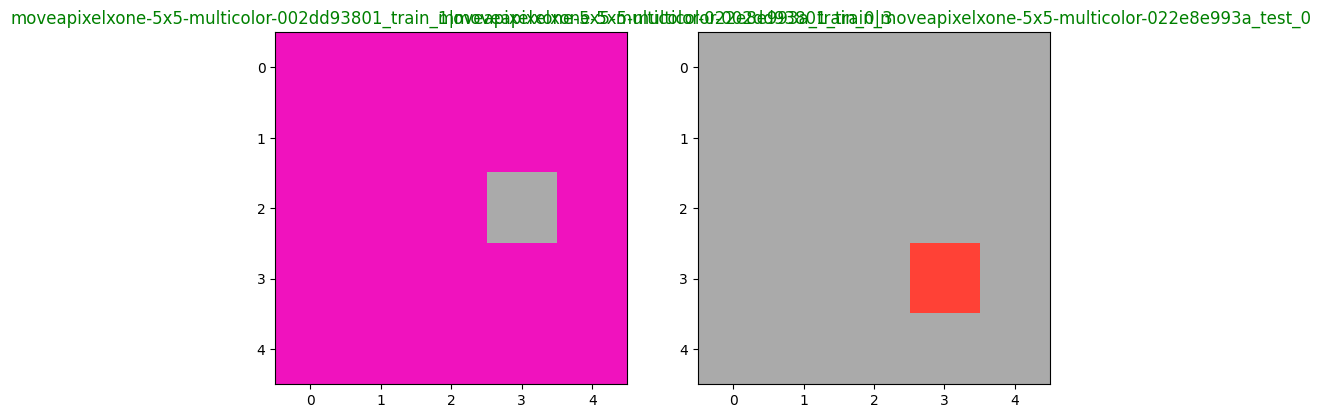

In [22]:
# Visualize any randome image along with the mask
def plot_one(ax, data, name, trim=False):
    grid = gsb_to_grid(data)
    tl_color = 'green' if np.all(grid == grid) else 'red'
    grid = trim_grid(grid) if trim else grid
    xx=grid_to_rgb(grid)
    ax.imshow(xx)
    ax.set_title(name, color=tl_color)

print("Grid Recovery")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 7))
idx = 10 # next(i for i, s in enumerate(names) if s.startswith('moveapixelxone-5x5-f5c8a0d2f3'))
plot_one(ax1, data[idx][0][0], names[idx])

# print("Sanity Check:\nA rotated gsb should show '[ 0.96242838 -0.16512661  0.56377749]'")
print("Sanity Check:\nA rotated gsb should show '[ 0.53565169  0.61520348  0.10667071]'")
print(data[idx][0][0][0][0]) # idx, encoder. input, top, left.

idx = 10 # next(i for i, s in enumerate(test_names) if s.endswith('d4146d7159_test_1'))
plot_one(ax2, test_data[idx][1][0], test_names[idx])

## Start and End Tokens

In [23]:
def token_gen(pattern_str):
    ps = pattern_str.split('|')
    print(ps)
    ps_grid = np.array([ list(map(int, list(s))) for s in ps ])
    black = ps_grid == 0
    white = ps_grid == 1
    token_grid = black * 4 + white * 0 # Flip the code to black.
    return pad_grid(token_grid)

['11111', '10001', '10101', '10001', '11111']
['01110', '10101', '11011', '10101', '01110']


Text(0.5, 1.0, 'End')

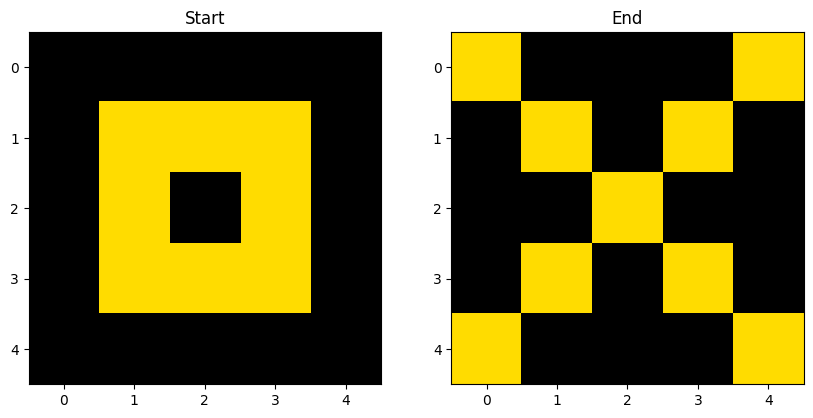

In [24]:
# QR code for "START_TASK" and "END_TASK"
# start_task_grid = token_gen(
# '111111100100001111111|100000100011101000001|101110100010001011101|101110100110001011101|\
# 101110100011101011101|100000101000001000001|111111101010101111111|000000000010000000000|\
# 100101101101110100000|011010011011010100000|111000110111001100101|111100001010101101000|\
# 110000101001011110101|000000001000000011010|111111100001111110110|100000101010000010011|\
# 101110100100111111110|101110101000010000011|101110100101010110001|100000100111100110000|111111101100000110110')
# end_task_grid   = token_gen(
# '111111100110001111111|100000101101001000001|101110100010001011101|101110100011001011101|\
# 101110101111101011101|100000100101001000001|111111101010101111111|000000000010000000000|\
# 101010100010100010010|111010000011011100110|101100101111010110011|011101010001110010000|\
# 011110110001001010111|000000001000001000010|111111100010100110111|100000100010001000010|\
# 101110101000101011100|101110100111010100110|101110101111011111001|100000100101110100010|111111101011011111111')
start_task_grid = token_gen('11111|10001|10101|10001|11111')
end_task_grid   = token_gen('01110|10101|11011|10101|01110')
STOP_TOKEN = grid_to_gsb(end_task_grid)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 7))

ax1.imshow(grid_to_rgb(start_task_grid))
ax1.grid(False)
ax1.set_title("Start")

ax2.imshow(grid_to_rgb(end_task_grid))
ax2.grid(False)
ax2.set_title("End")

# Preprocessing

The Data Loaded: (Batch, Encoder/Decoder, Seq, X, Y, Channels)

## Data Parameters

In [25]:
# maxlen - max sequence length
encoder_maxlen = 2
decoder_maxlen = 3
GRID_SHAPE = (FG,FG,3)
zero_grid = np.zeros(GRID_SHAPE)
BUFFER_SIZE = 20000
BATCH_SIZE = 8

## Construct Training and Test Set

In [31]:
class ModelData():
    def __init__(self, data, names, attrs):
        self.data   = data
        self.names  = names
        self.attrs  = attrs
        self.enc_inp       = None
        self.enc_inp_model = None
        self.enc_seq_mask  = None
        self.dec_inp       = None
        self.dec_inp_model = None
        self.dec_seq_mask  = None
        self.batches = None
        self._unpack()
        self._repackage()

    def _unpack(self):
        """
        The data's shape is (Batch, Encoder/Decoder, Seq, X, Y, Channels)
        This function split them up and reorganize them into a form more suitable for training and testing.
        . First it separates the Encoder / Decoder Sets as there are different entry points. (Batch, Seq, X, Y, Channels) x 2
        . It adds the STOP token to the decoder sequence.
        """
        print("Unpacking...")
        # np.split separates encoder from decoder => (Batch, 1, Seq, X, Y, Channels), (Batch, 1, Seq, X, Y, Channels)
        # np.squeeze removed the single dim => (Batch, Seq, X, Y, Channels), (Batch, Seq, X, Y, Channels)
        self.enc_inp, self.dec_inp = np.squeeze(np.split(self.data, len(self.data[0]), axis=1))

        ####
        # Encoder - the split output is the result.
        print("Encoder Input Shape: {}".format(self.enc_inp.shape))

        ####
        # Decoder
        # Splits the Sequence into it's constituents (Batch, X, Y, Channels)
        seq = np.squeeze(np.split(self.dec_inp, len(self.dec_inp[0]), axis=1))
        # print([s.shape for s in seq])
        # Attach a STOP_TOKEN to the entire batch (Batch, X, Y, Channels)
        all_stop     = np.repeat([STOP_TOKEN], repeats=self.dec_inp.shape[0], axis=0) # repeat for the entire batch.
        self.dec_inp = np.stack([seq[0], seq[1], all_stop], axis=1)
        # Associate the same names since it is the same task.
        print("Decoder Input Shape: {}".format(self.dec_inp.shape))

    def _repackage(self):
        print("Repackaging...")
        print("Encoder")
        self.enc_inp_model, self.enc_seq_mask = self._repack(self.enc_inp, encoder_maxlen)
        print("Decoder")
        self.dec_inp_model, self.dec_seq_mask = self._repack(self.dec_inp, decoder_maxlen)
        print(self.enc_inp_model.shape, self.dec_inp_model.shape)

    def _repack(self, data_array, max_seq_length):
        """
        Create structures as required by the model feature length
        Padding/Truncating sequences for identical sequence lengths
        """
        print("Original\t", data_array.shape) # (Batch, Seq, X, Y, Channels)
        # print(data_array[0]) # Entry 0

        ######
        # Create the zero grid padded version (batch, max_len, GRID_SHAPE[0], GRID_SHAPE[1], GRID_SHAPE[2])
        # required as model feature length
        standardized = np.array([ np.concatenate((i, np.tile(zero_grid,(max(max_seq_length-len(i),0),1,1,1))), axis=0) for i in data_array ])
        print("Zero Padded\t", standardized.shape)

        ######
        # Mask: Create the 0 padded (batch, max_len) representaion of the data
        # This is to be used in create_masks.
        # Form [ [ 1's * Seq  ] * Batch ], i.e. for data (10, 2, 5, 5, 3),
        # forms [ [ 1, 1 ] * 10 ] where the inner list is an np.array
        seq_mask = [ np.ones((len(i)), dtype=np.int32) for i in data_array ]
        # Then pad with 0 as a mask to fill the length to max_seq_length,
        # required as model feature length
        seq_mask = tf.keras.preprocessing.sequence.pad_sequences(seq_mask, maxlen=max_seq_length, padding='post', truncating='post')
        print("Sequence Mask\t", seq_mask.shape,seq_mask[0])

        return standardized, seq_mask

    def prepare_batch(self, enc, dec):
        print(enc)
        print(dec)
        enc_batch = tf.convert_to_tensor(enc)  # Convert to 0-padded dense Tensor

        dec_batch  = tf.convert_to_tensor(dec[:, :-1])  # Drop the [END] tokens
        dec_labels = tf.convert_to_tensor(dec[:, 1: ])  # Drop the first tokens

        return (enc_batch, dec_batch), dec_labels

    def make_batches(self, ds):
        return (
          ds
          .shuffle(BUFFER_SIZE)
          .batch(BATCH_SIZE)
          .map(self.prepare_batch, tf.data.AUTOTUNE)
          .prefetch(buffer_size=tf.data.AUTOTUNE))

    def shuffle_and_batch(self):
        print("Shuffling... use ModelData.batches to retrieve")
        ds = tf.data.Dataset.from_tensor_slices((self.enc_inp_model, self.dec_inp_model))
        self.batches = self.make_batches(ds)
        print(self.batches)

    def plot_task(self, task_id):
        fig, axes = plt.subplots(2, 3, figsize = (15, 15))
        print(self.names[task_id])
        plot_one(axes[0,0], self.enc_inp[task_id][0], self.names[task_id], trim=False)
        plot_one(axes[0,1], self.enc_inp[task_id][1], self.names[task_id], trim=False)
        axes[0,2].axis('off')
        plot_one(axes[1,0], self.dec_inp[task_id][0], self.names[task_id], trim=False)
        plot_one(axes[1,1], self.dec_inp[task_id][1], self.names[task_id], trim=False)
        plot_one(axes[1,2], self.dec_inp[task_id][2], self.names[task_id], trim=False)

In [32]:
training_set = ModelData(data, names, attrs)
validatn_set = ModelData(test_data, test_names, test_attrs)

Unpacking...
Encoder Input Shape: (4728, 2, 5, 5, 3)
Decoder Input Shape: (4728, 3, 5, 5, 3)
Repackaging...
Encoder
Original	 (4728, 2, 5, 5, 3)
Zero Padded	 (4728, 2, 5, 5, 3)
Sequence Mask	 (4728, 2) [1 1]
Decoder
Original	 (4728, 3, 5, 5, 3)
Zero Padded	 (4728, 3, 5, 5, 3)
Sequence Mask	 (4728, 3) [1 1 1]
(4728, 2, 5, 5, 3) (4728, 3, 5, 5, 3)
Unpacking...
Encoder Input Shape: (1052, 2, 5, 5, 3)
Decoder Input Shape: (1052, 3, 5, 5, 3)
Repackaging...
Encoder
Original	 (1052, 2, 5, 5, 3)
Zero Padded	 (1052, 2, 5, 5, 3)
Sequence Mask	 (1052, 2) [1 1]
Decoder
Original	 (1052, 3, 5, 5, 3)
Zero Padded	 (1052, 3, 5, 5, 3)
Sequence Mask	 (1052, 3) [1 1 1]
(1052, 2, 5, 5, 3) (1052, 3, 5, 5, 3)


In [33]:
training_set.shuffle_and_batch()
validatn_set.shuffle_and_batch()

Shuffling... use ModelData.batches to retrieve
Tensor("args_0:0", shape=(None, 2, 5, 5, 3), dtype=float64)
Tensor("args_1:0", shape=(None, 3, 5, 5, 3), dtype=float64)
<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 2, 5, 5, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 2, 5, 5, 3), dtype=tf.float64, name=None)), TensorSpec(shape=(None, 2, 5, 5, 3), dtype=tf.float64, name=None))>
Shuffling... use ModelData.batches to retrieve
Tensor("args_0:0", shape=(None, 2, 5, 5, 3), dtype=float64)
Tensor("args_1:0", shape=(None, 3, 5, 5, 3), dtype=float64)
<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 2, 5, 5, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 2, 5, 5, 3), dtype=tf.float64, name=None)), TensorSpec(shape=(None, 2, 5, 5, 3), dtype=tf.float64, name=None))>


In [34]:
print(training_set.batches)
print(validatn_set.batches)

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 2, 5, 5, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 2, 5, 5, 3), dtype=tf.float64, name=None)), TensorSpec(shape=(None, 2, 5, 5, 3), dtype=tf.float64, name=None))>
<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 2, 5, 5, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 2, 5, 5, 3), dtype=tf.float64, name=None)), TensorSpec(shape=(None, 2, 5, 5, 3), dtype=tf.float64, name=None))>


moveapixelxone-5x5-multicolor-034514d1fb_train_1|moveapixelxone-5x5-multicolor-034514d1fb_train_2


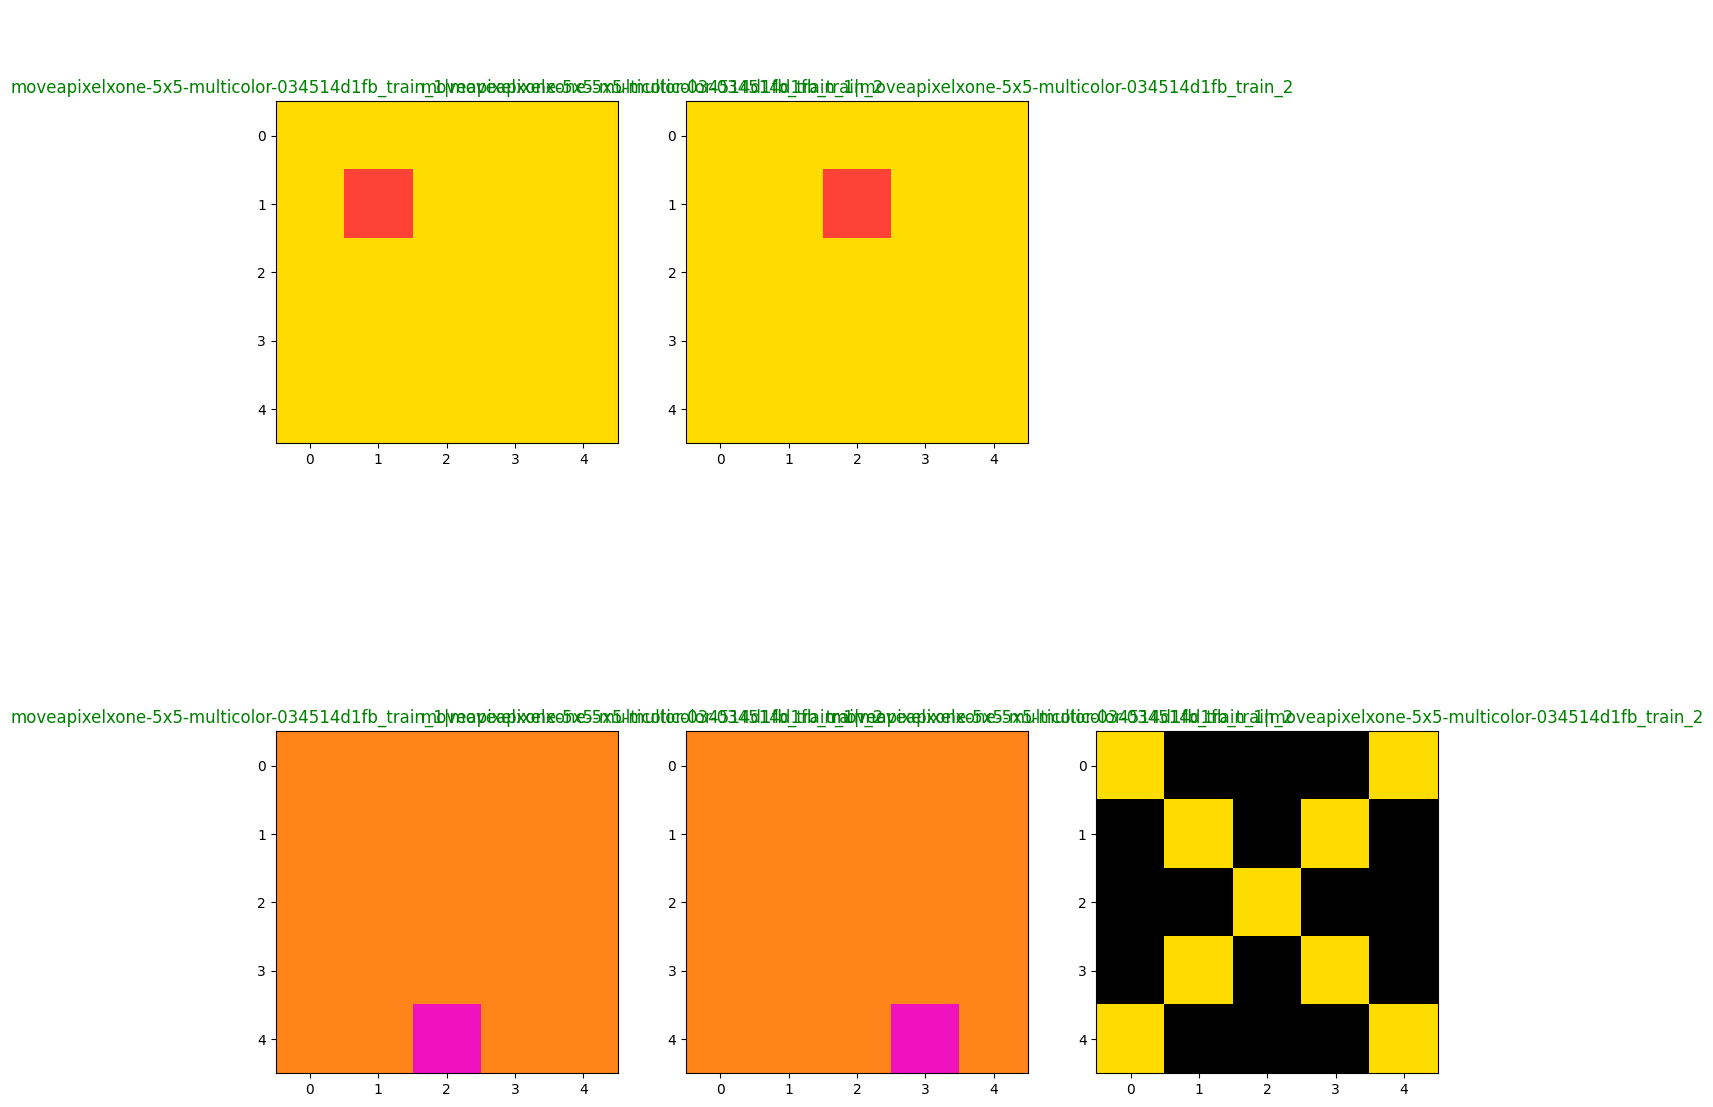

In [35]:
# Take a look at a random task.
task_id = 100
training_set.plot_task(task_id)

# Building the Model

## Embedding Layer (Adapted)

In [36]:
class EmbeddingLayer(tf.keras.layers.Layer):
    # say seq_len = 4,
    # Then each should go through the same embedding weights,
    # yield dimention d_model
    #
    # So:
    # Input  (batch_size, seq_len, FG, FG, 3)
    # Output (batch_size, seq_len, d_model)
    #
    def __init__(self, in_shape, d_model):
        super(EmbeddingLayer, self).__init__()

        self.raw  = tf.keras.Input(in_shape,name="raw")
        self.flat = tf.keras.layers.Flatten(name="raw_flatten")(self.raw)
        print("EmbeddingLayer")
        print("Raw Flatten", self.flat.shape)

        # CNN Layer(s)
        # print(self.raw)
        self.cnn1 = tf.keras.layers.Conv2D(filters=1,kernel_size=(3,3),strides=(1,1),padding="same", name="cnn1")(self.raw) # activation?
        print("CNN 1", self.cnn1.shape)
        self.cnn1 = tf.keras.layers.MaxPooling2D(pool_size=(3, 3),strides=(1,1),padding='valid')(self.cnn1)
        print("MaxPooled", self.cnn1.shape)
        self.cnn1 = tf.keras.layers.Flatten(name="cnn1_flatten")(self.cnn1)
        print("CNNLayer", self.cnn1.shape)

        # Concat
        self.merged = tf.keras.layers.concatenate([self.flat, self.cnn1], axis=-1)
        self.merged = tf.keras.layers.Dense(d_model, activation='relu', kernel_initializer="he_normal", name="dense")(self.merged)
        print("Merged", self.merged.shape)

        self.encoder = tf.keras.Model(inputs=[self.raw],outputs=[self.merged], name = "cnn")

    def call(self, x, training):
        # Apply the same encoder to each element in the sequence
        seq = tf.unstack(x, axis=1)
        emb = [ self.encoder( s ) for s in seq ]
        output = tf.stack(emb, axis=1)

        return output

## Positional Encoding (Adapted)

In [37]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)

In [38]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, length, embedding_layer, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = embedding_layer
    self.pos_encoding = positional_encoding(length=length, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

## Base Attention Layer

In [39]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

## Cross Attention Layer

In [40]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)

    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

## Global Self-Attention Layer

In [41]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

## Causal Self-Attention Layer

In [42]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

## Feed Forward Network

In [43]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)
    return x

## Encoder Layer

In [44]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

## Encoder (Adapted)

In [45]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               pos_enc_len, embedding_layer,
               dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        length=pos_enc_len, embedding_layer=embedding_layer, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.


## Decoder Layer

In [46]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

    self.last_attn_scores = None

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x


## Decoder (Adapted)

In [47]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               pos_enc_len, embedding_layer,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(length=pos_enc_len,
                                             embedding_layer=embedding_layer,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

## The Transformer (Adapted)

In [48]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               enc_len, dec_len, embedding_layer, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           pos_enc_len=enc_len,
                           embedding_layer=embedding_layer,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers*2, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           pos_enc_len=dec_len,
                           embedding_layer=embedding_layer,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.models.Sequential()
    self.final_layer.add( tf.keras.layers.Dense(np.prod(GRID_SHAPE)) )
    self.final_layer.add( tf.keras.layers.Reshape((-1,GRID_SHAPE[0],GRID_SHAPE[1],GRID_SHAPE[2])) ) # <- what's the right param?

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    context, target = inputs # enc, dec

    context = self.encoder(context)  # (batch_size, context_len, d_model)

    x = self.decoder(target, context)  # (batch_size, target_len, d_model)

    # Final linear layer output.
    final_output = self.final_layer(x)  # (batch_size, target_len, GRID_SHAPE[0], GRID_SHAPE[1], GRID_SHAPE[2])

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del final_output._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return final_output



# Training Set Up

## Hyperparameters

In [50]:
# hyper-params
num_layers = 1
d_model = 64 # 128
dff = 256
num_heads = 1 # 8
EPOCHS = 120
dropout = 0.1
lr = 1e-03
lr_patience = 8
lr_factor = 0.8

## Transformer

In [51]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    enc_len=encoder_maxlen,
    dec_len=decoder_maxlen,
    embedding_layer=EmbeddingLayer( in_shape=GRID_SHAPE, d_model=d_model),
    dropout_rate=dropout)

EmbeddingLayer
Raw Flatten (None, 75)
CNN 1 (None, 5, 5, 1)
MaxPooled (None, 3, 3, 1)
CNNLayer (None, 9)
Merged (None, 64)


In [52]:
# Test it:
output = transformer((training_set.enc_inp_model, training_set.dec_inp_model))

In [53]:
attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
print(attn_scores.shape)  # (batch, heads, target_seq, input_seq)

(4728, 1, 3, 2)


In [54]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  55452     
                                                                 
 decoder (Decoder)           multiple                  138972    
                                                                 
 sequential_3 (Sequential)   (4728, 3, 5, 5, 3)        4875      
                                                                 
Total params: 193831 (757.15 KB)
Trainable params: 193831 (757.15 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Set up the optimizer

In [60]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=15000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [61]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

## Test the custom learning rate scheduler:

Text(0.5, 0, 'Train Step')

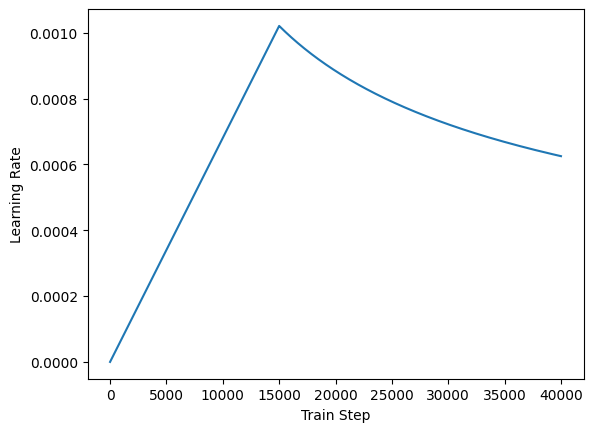

In [62]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

## Adapt the loss and metrics

In [63]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.MeanSquaredError()
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

# Need to use gsb_to_grid
def masked_accuracy(label, pred):

  print(pred.shape, label.shape)
  #      latest = np.array(predictions[-1,-1])
  #      if not stop_detected:
  #          stop_detected = np.all(np.equal(gsb_to_grid(latest), end_task_grid))

  # pred  = tf.argmax(pred, axis=2)
  # label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0
  # match = match & mask
  # match = tf.cast(match, dtype=tf.float32)
  # mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

def get_lr_metric(optimizer):
  def lr(y_true, y_pred):
      return optimizer.lr # I use ._decayed_lr method instead of .lr
  return lr

# Training

In [64]:
transformer.compile(
   loss=masked_loss,
   optimizer=optimizer,
   metrics=[tf.keras.metrics.Accuracy(), get_lr_metric(optimizer)] # [masked_accuracy] #
)

In [65]:
history = transformer.fit(
      training_set.batches,
      epochs=EPOCHS,
      validation_data=validatn_set.batches)


Epoch 1/120
591/591 [==============================] - 31s 26ms/step - loss: 0.7280 - accuracy: 0.0000e+00 - lr: 2.0072e-05 - val_loss: 0.2183 - val_accuracy: 0.0000e+00 - val_lr: 4.0144e-05
Epoch 2/120
591/591 [==============================] - 15s 26ms/step - loss: 0.2089 - accuracy: 0.0000e+00 - lr: 6.0285e-05 - val_loss: 0.1658 - val_accuracy: 0.0000e+00 - val_lr: 8.0357e-05
Epoch 3/120
591/591 [==============================] - 14s 24ms/step - loss: 0.1655 - accuracy: 0.0000e+00 - lr: 1.0050e-04 - val_loss: 0.1445 - val_accuracy: 0.0000e+00 - val_lr: 1.2057e-04
Epoch 4/120
591/591 [==============================] - 16s 27ms/step - loss: 0.1353 - accuracy: 0.0000e+00 - lr: 1.4071e-04 - val_loss: 0.1092 - val_accuracy: 0.0000e+00 - val_lr: 1.6078e-04
Epoch 5/120
591/591 [==============================] - 16s 26ms/step - loss: 0.1028 - accuracy: 0.0000e+00 - lr: 1.8092e-04 - val_loss: 0.0793 - val_accuracy: 0.0000e+00 - val_lr: 2.0099e-04
Epoch 6/120
591/591 [========================

# Stats

## Learning Curve

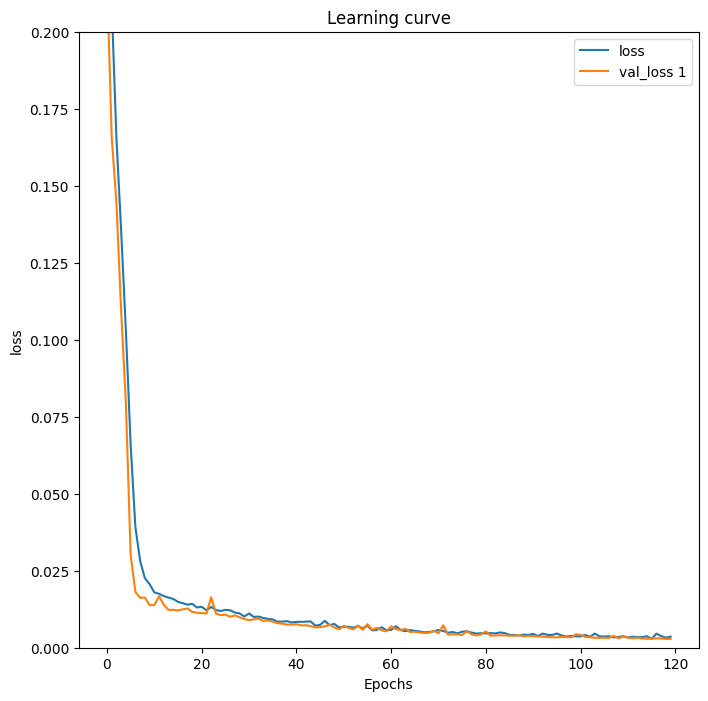

In [66]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label = "val_loss 1")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.ylim(0, 0.2)
plt.legend();
# transformer.summary()

## Survey Model Weights

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  55452     
                                                                 
 decoder (Decoder)           multiple                  138972    
                                                                 
 sequential_3 (Sequential)   (None, None, 5, 5, 3)     4875      
                                                                 
Total params: 193831 (757.15 KB)
Trainable params: 193831 (757.15 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


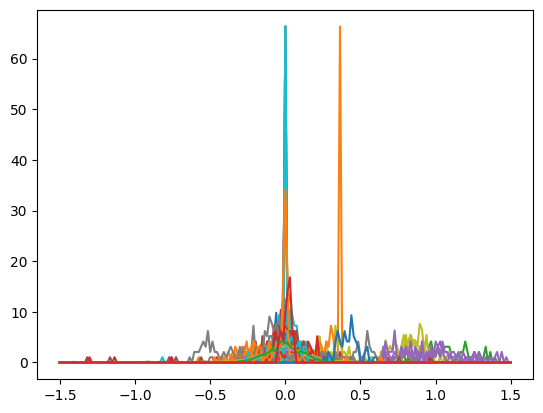

In [67]:
transformer.summary()
# weights = transformer.get_weights()
for w in transformer.trainable_weights:
    # print(np.sum(np.isnan(w)))
    pr, _ = np.histogram(w, bins=np.linspace(-1.5, 1.5, 200), density=True)
    plt.plot(np.linspace(-1.5, 1.5, len(pr)), pr) # , label='real', color='g', linewidth=2)

/usr/local/lib/python3.10/dist-packages/numpy/lib/histograms.py:885: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
/usr/local/lib/python3.10/dist-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


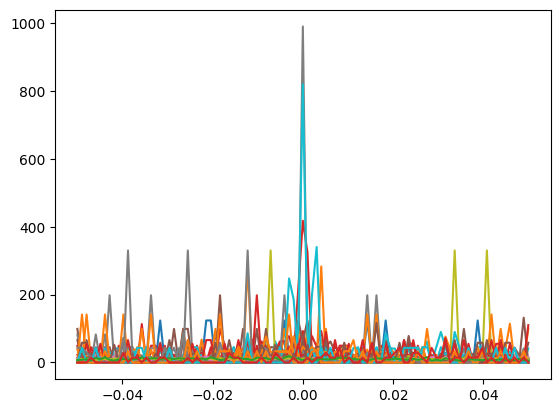

In [68]:
for w in transformer.trainable_weights:
    # print(np.sum(np.isnan(w)))
    pr, _ = np.histogram(w, bins=np.linspace(-0.05, 0.05, 100), density=True)
    plt.plot(np.linspace(-0.05, 0.05, len(pr)), pr) # , label='real', color='g', linewidth=2)
# plt.clf()

# Inference

In [69]:
loss_function=tf.keras.losses.MeanSquaredError()

In [70]:
# Predicting one token at a time at the decoder and appending it to the output;
# then taking the complete sequence as an input to the decoder,
# repeating until maxlen or stop keyword appears
def predict(model, encoder_input, decoder_input):

    stop_detected = False

    # maxlen = decoder_maxlen # tar_len if tar_len else decoder_maxlen
    for i in range(decoder_maxlen-1):
        predictions = model( (encoder_input, decoder_input) )
        latest = np.array(predictions[-1,-1])
        if not stop_detected:
            stop_detected = np.all(np.equal(gsb_to_grid(latest), end_task_grid))
        latest_append = np.array(np.expand_dims(latest, axis=(0,1)))
        decoder_input = np.concatenate([decoder_input, latest_append], axis=1)

    return tf.squeeze(decoder_input, axis=0), stop_detected # attention_weights


## Solving and Plotting Utilities

In [71]:
def solve_one(model, inp, tar):
    inp_ = np.expand_dims(inp, axis=0)
    tar_ = np.expand_dims(tar[0], axis=(0,1))
    pred, stop_detected = predict(model, inp_, tar_)
    loss = loss_function(tar, pred)
    return pred, loss, stop_detected

In [72]:
def test_step(validatn_set, batch_size):
    (inp, tar, inp_pad, tar_pad) = validatn_set
    for idx in range(batch_size):
        _, loss, _ = solve_one(inp[idx], tar[idx], inp_pad[idx], tar_pad[idx])
        val_loss(loss)

In [73]:
def is_exact_match(target, prediction):
    tar_grid = np.array(list(map(gsb_to_grid, target)))
    pred_grid= np.array(list(map(gsb_to_grid, prediction.numpy())))
    return np.all(np.equal(tar_grid,pred_grid))

In [87]:
# Plot task grids
def plot_task( inp, tar, pred, idx ):
    fig, axes = plt.subplots(1, len(inp[idx]), figsize = (3, 9))
    for i in range(len(inp[idx])):
        plot_one(axes[i], np.array(inp[idx][i]), "", trim=False)
    fig, axes = plt.subplots(1, len(tar[idx]), figsize = (6, 9))
    for i in range(len(tar[idx])):
        plot_one(axes[i], np.array(tar[idx][i]), "", trim=False)
    fig, axes = plt.subplots(1, len(pred), figsize = (6, 9))
    for i in range(len(pred)):
        plot_one(axes[i], np.array(pred[i]), "", trim=False)

In [80]:
def solve_and_plot(model, from_dataset, idxs=None):

    inp_names    = from_dataset.names
    target_names = from_dataset.names
    inp           = from_dataset.enc_inp_model
    tar           = from_dataset.dec_inp_model

    if not idxs:
        # Pick a random one
        idxs = [np.random.randint(0, len(inp))]

    count=0
    for idx in idxs:
        print("Task index: {}, Input: {}, Target: {}".format(idx, inp_names[idx], target_names[idx]))
        # Run prediction
        pred, loss, stop_detected = solve_one(model, inp[idx], tar[idx])
        accurate = is_exact_match(tar[idx], pred)
        print("Result Elements: {}, Accurate: {}, Shape: {}, Stopped: {}".format(len(pred), accurate, pred.shape, stop_detected))
        print("Loss", loss)
        plot_task( inp, tar, pred, idx )
        count+=1
        if count == 10: break

## Score Test Set

In [77]:
val_loss   = tf.keras.metrics.Mean(name='val_loss')

def score(model, data_set):

  val_loss.reset_states()
  stops_found=0
  accurate=[]

  inp           = data_set.enc_inp_model
  tar           = data_set.dec_inp_model
  for idx in range(len(inp)):
      pred, loss, stop_detected = solve_one(model, inp[idx], tar[idx])
      if is_exact_match(tar[idx], pred):
          accurate.append(idx)
      val_loss(loss)
      stops_found+= stop_detected
      if idx % np.around(len(inp) / 10) == 0:
          print("processed", idx)

  print("Count: {}, Avg loss: {:.4f}, Accuracy: {} ({:.4f}), Stops found: {}".format(len(inp), val_loss.result(), len(accurate), len(accurate)/len(inp), stops_found))
  return accurate

In [95]:
correct_idxs = score(transformer, validatn_set)
print(correct_idxs)

processed 0
processed 105
processed 210
processed 315
processed 420
processed 525
processed 630
processed 735
processed 840
processed 945
processed 1050
Count: 1052, Avg loss: 0.0019, Accuracy: 557 (0.5295), Stops found: 1052
[0, 4, 5, 7, 8, 9, 11, 14, 15, 16, 17, 18, 19, 21, 22, 24, 28, 29, 30, 33, 34, 35, 37, 39, 42, 43, 44, 46, 47, 50, 51, 52, 53, 55, 60, 62, 64, 65, 66, 67, 68, 69, 70, 71, 73, 74, 76, 80, 81, 82, 87, 88, 89, 90, 91, 94, 95, 96, 99, 101, 103, 106, 108, 112, 113, 114, 115, 116, 117, 118, 120, 121, 122, 124, 125, 126, 132, 133, 135, 136, 139, 140, 143, 144, 149, 151, 153, 155, 156, 159, 161, 163, 168, 169, 170, 172, 173, 177, 178, 181, 182, 186, 188, 189, 190, 192, 193, 195, 200, 201, 202, 203, 205, 207, 208, 209, 210, 213, 215, 216, 218, 219, 221, 222, 228, 230, 231, 232, 233, 234, 238, 239, 242, 243, 244, 245, 246, 247, 248, 250, 251, 252, 254, 256, 259, 260, 262, 264, 265, 268, 270, 272, 274, 276, 277, 279, 281, 282, 283, 284, 288, 290, 291, 292, 293, 294, 299, 302

Task index: 0, Input: moveapixelxone-5x5-multicolor-00027b7a3b_train_0|moveapixelxone-5x5-multicolor-00027b7a3b_test_0, Target: moveapixelxone-5x5-multicolor-00027b7a3b_train_0|moveapixelxone-5x5-multicolor-00027b7a3b_test_0
Result Elements: 3, Accurate: True, Shape: (3, 5, 5, 3), Stopped: True
Loss tf.Tensor(0.001020472963374798, shape=(), dtype=float64)
Task index: 4, Input: moveapixelxone-5x5-multicolor-00cca53ba5_train_0|moveapixelxone-5x5-multicolor-00cca53ba5_test_0, Target: moveapixelxone-5x5-multicolor-00cca53ba5_train_0|moveapixelxone-5x5-multicolor-00cca53ba5_test_0
Result Elements: 3, Accurate: True, Shape: (3, 5, 5, 3), Stopped: True
Loss tf.Tensor(0.0007842618386113827, shape=(), dtype=float64)
Task index: 5, Input: moveapixelxone-5x5-multicolor-00da191a30_train_0|moveapixelxone-5x5-multicolor-00da191a30_test_0, Target: moveapixelxone-5x5-multicolor-00da191a30_train_0|moveapixelxone-5x5-multicolor-00da191a30_test_0
Result Elements: 3, Accurate: True, Shape: (3, 5, 5, 3), S

<ipython-input-87-77614daf4bfa>:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, len(pred), figsize = (6, 9))


Result Elements: 3, Accurate: True, Shape: (3, 5, 5, 3), Stopped: True
Loss tf.Tensor(0.0008103814889244336, shape=(), dtype=float64)
Task index: 15, Input: moveapixelxone-5x5-multicolor-02ac8be2b1_train_0|moveapixelxone-5x5-multicolor-02ac8be2b1_test_0, Target: moveapixelxone-5x5-multicolor-02ac8be2b1_train_0|moveapixelxone-5x5-multicolor-02ac8be2b1_test_0
Result Elements: 3, Accurate: True, Shape: (3, 5, 5, 3), Stopped: True
Loss tf.Tensor(0.0007399178559488144, shape=(), dtype=float64)
Task index: 16, Input: moveapixelxone-5x5-multicolor-02c52d143b_train_0|moveapixelxone-5x5-multicolor-02c52d143b_test_0, Target: moveapixelxone-5x5-multicolor-02c52d143b_train_0|moveapixelxone-5x5-multicolor-02c52d143b_test_0
Result Elements: 3, Accurate: True, Shape: (3, 5, 5, 3), Stopped: True
Loss tf.Tensor(0.0006623937290938351, shape=(), dtype=float64)


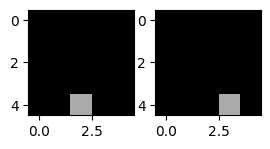

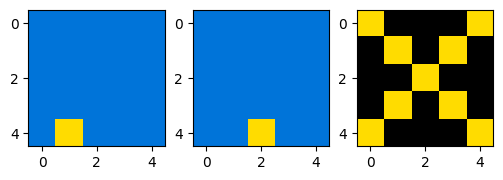

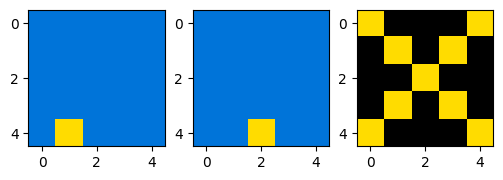

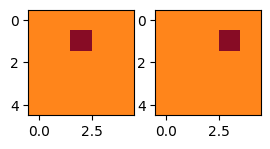

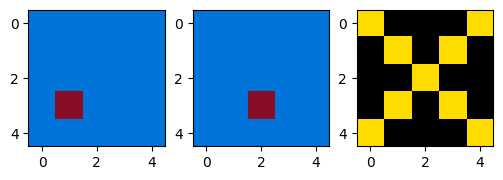

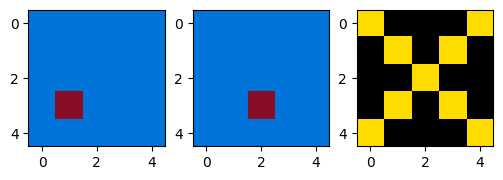

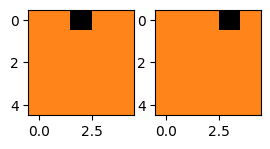

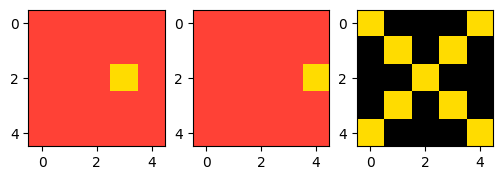

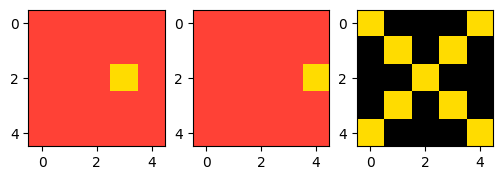

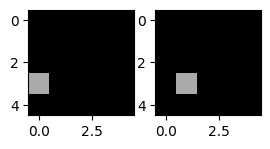

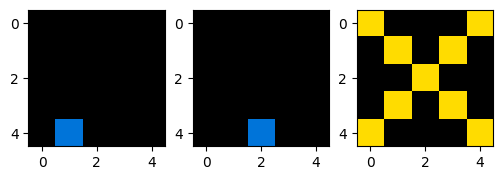

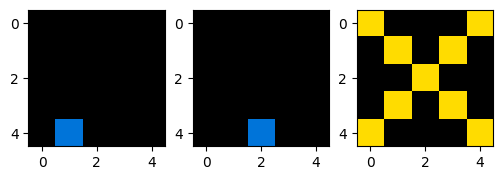

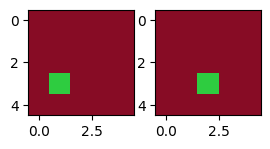

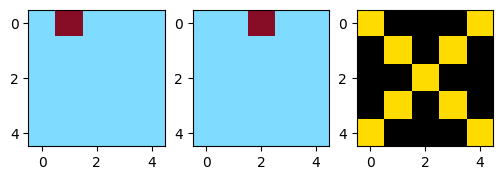

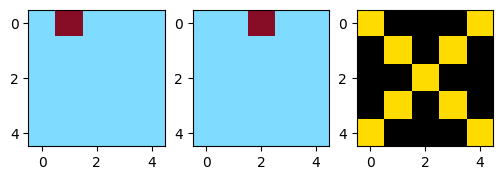

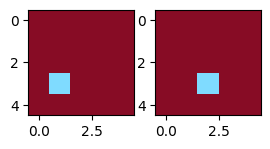

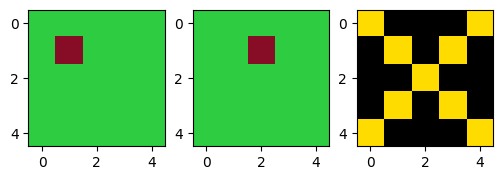

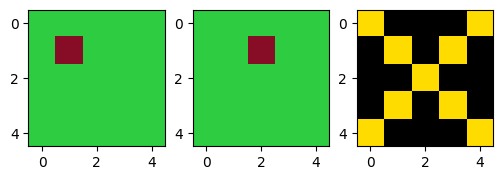

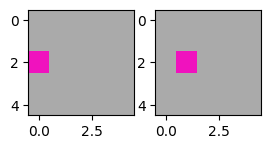

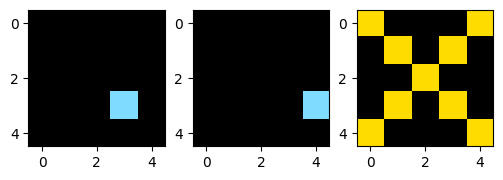

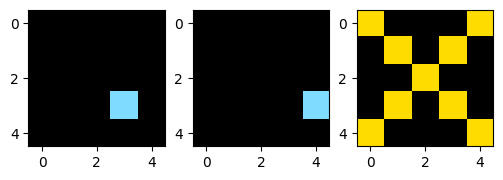

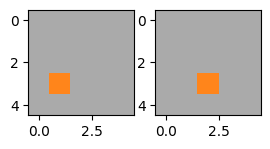

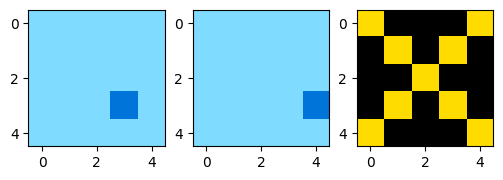

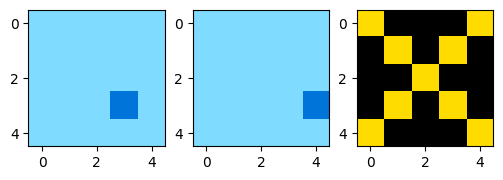

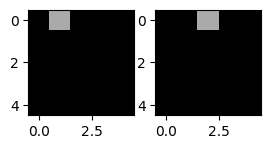

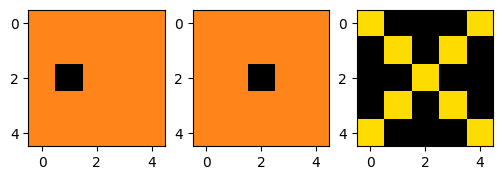

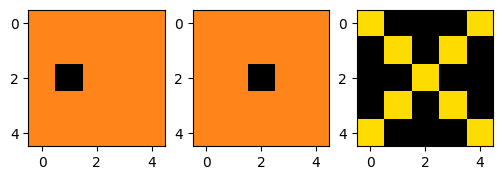

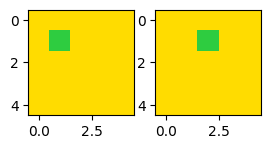

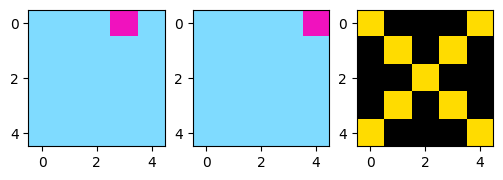

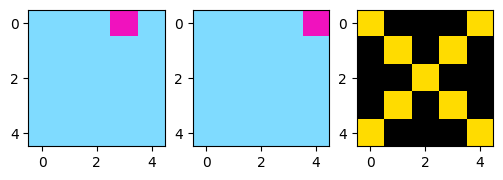

In [96]:
solve_and_plot(transformer, validatn_set, correct_idxs)

## Random Pick from Test Set

Task index: 541, Input: moveapixelxone-5x5-multicolor-836ec45012_train_0|moveapixelxone-5x5-multicolor-836ec45012_test_0, Target: moveapixelxone-5x5-multicolor-836ec45012_train_0|moveapixelxone-5x5-multicolor-836ec45012_test_0
Result Elements: 3, Accurate: False, Shape: (3, 5, 5, 3), Stopped: True
Loss tf.Tensor(0.0038841621800123818, shape=(), dtype=float64)


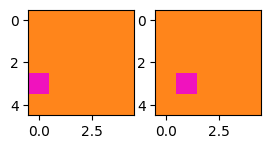

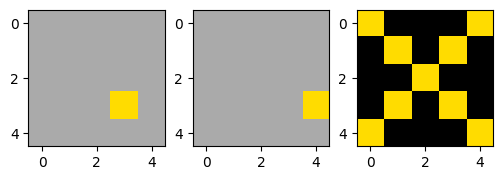

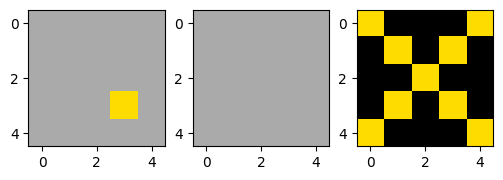

In [97]:
solve_and_plot(transformer, validatn_set)

## Score Train Set

In [83]:
correct_idxs = score(transformer, training_set)
print(correct_idxs)

processed 0
processed 473
processed 946
processed 1419
processed 1892
processed 2365
processed 2838
processed 3311
processed 3784
processed 4257
Count: 4728, Avg loss: 0.0007, Accuracy: 4208 (0.8900), Stops found: 4728
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 86, 87, 88, 90, 91, 92, 93, 94, 95, 96, 97, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 124, 125, 126, 127, 130, 131, 132, 133, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 195, 196, 197, 198, 203, 20

## Plot Correct Train Tasks

4208
[102, 2556, 2743, 150, 3824, 542, 1513, 4622, 1939, 2662]
Task index: 102, Input: moveapixelxone-5x5-multicolor-03b934b8a1_train_1|moveapixelxone-5x5-multicolor-03b934b8a1_train_1, Target: moveapixelxone-5x5-multicolor-03b934b8a1_train_1|moveapixelxone-5x5-multicolor-03b934b8a1_train_1
Result Elements: 3, Accurate: True, Shape: (3, 5, 5, 3), Stopped: True
Loss tf.Tensor(0.0003592588169638229, shape=(), dtype=float64)
Task index: 2556, Input: moveapixelxone-5x5-multicolor-8a0ff1eef3_train_2|moveapixelxone-5x5-multicolor-8a0ff1eef3_train_2, Target: moveapixelxone-5x5-multicolor-8a0ff1eef3_train_2|moveapixelxone-5x5-multicolor-8a0ff1eef3_train_2
Result Elements: 3, Accurate: True, Shape: (3, 5, 5, 3), Stopped: True
Loss tf.Tensor(0.0005980481425108645, shape=(), dtype=float64)
Task index: 2743, Input: moveapixelxone-5x5-multicolor-984b8d0486_train_1|moveapixelxone-5x5-multicolor-984b8d0486_train_3, Target: moveapixelxone-5x5-multicolor-984b8d0486_train_1|moveapixelxone-5x5-multicolor

<ipython-input-87-77614daf4bfa>:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, len(pred), figsize = (6, 9))


Task index: 4622, Input: moveapixelxone-5x5-multicolor-f8be8281af_train_1|moveapixelxone-5x5-multicolor-f8be8281af_train_2, Target: moveapixelxone-5x5-multicolor-f8be8281af_train_1|moveapixelxone-5x5-multicolor-f8be8281af_train_2
Result Elements: 3, Accurate: True, Shape: (3, 5, 5, 3), Stopped: True
Loss tf.Tensor(0.00029140359888708573, shape=(), dtype=float64)
Task index: 1939, Input: moveapixelxone-5x5-multicolor-65dc94d0dd_train_1|moveapixelxone-5x5-multicolor-65dc94d0dd_train_2, Target: moveapixelxone-5x5-multicolor-65dc94d0dd_train_1|moveapixelxone-5x5-multicolor-65dc94d0dd_train_2
Result Elements: 3, Accurate: True, Shape: (3, 5, 5, 3), Stopped: True
Loss tf.Tensor(0.0006204549618275157, shape=(), dtype=float64)
Task index: 2662, Input: moveapixelxone-5x5-multicolor-93cdd9f24a_train_1|moveapixelxone-5x5-multicolor-93cdd9f24a_train_1, Target: moveapixelxone-5x5-multicolor-93cdd9f24a_train_1|moveapixelxone-5x5-multicolor-93cdd9f24a_train_1
Result Elements: 3, Accurate: True, Shape

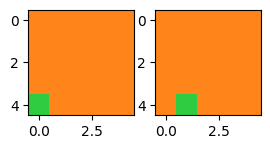

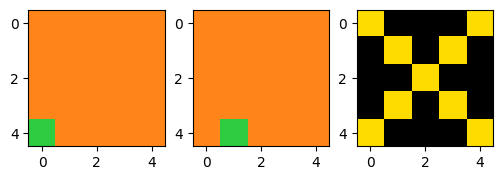

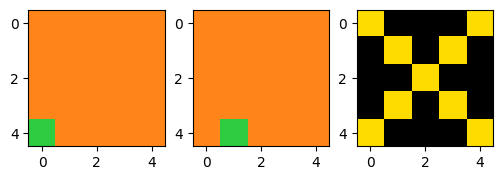

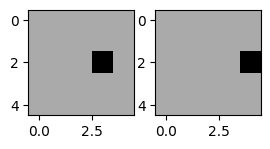

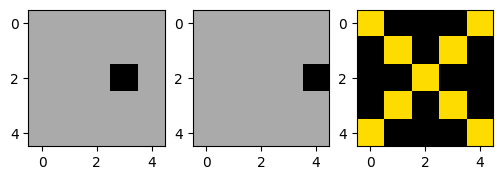

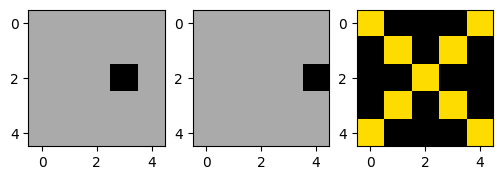

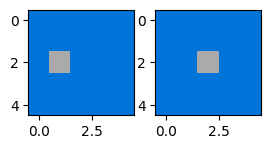

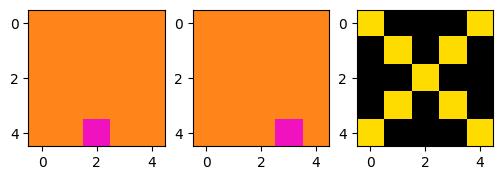

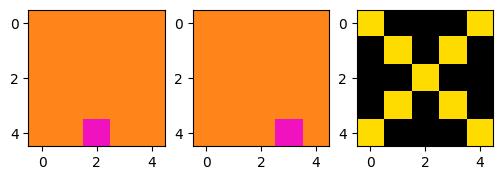

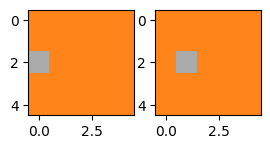

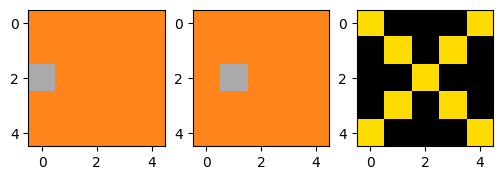

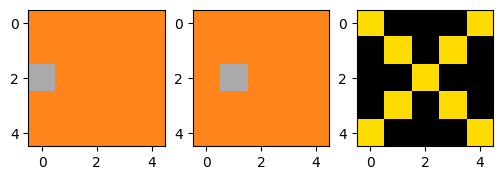

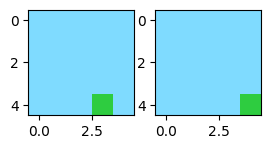

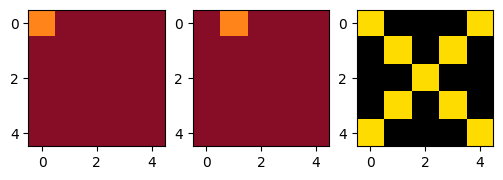

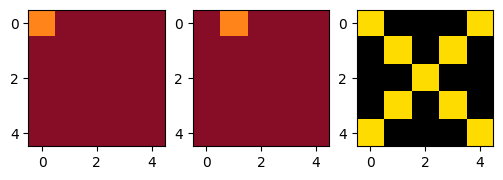

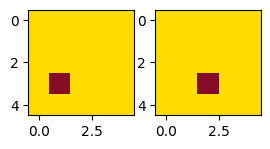

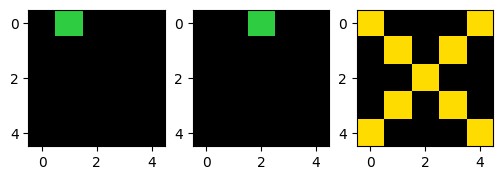

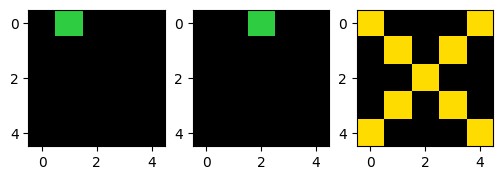

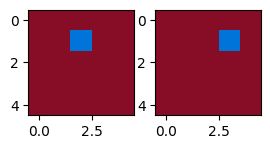

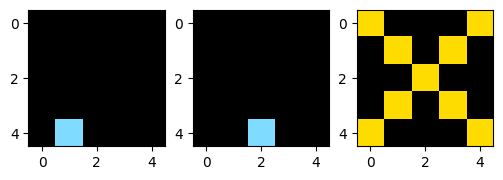

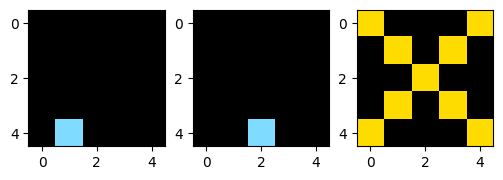

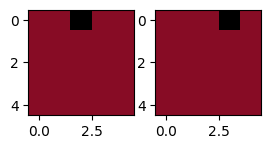

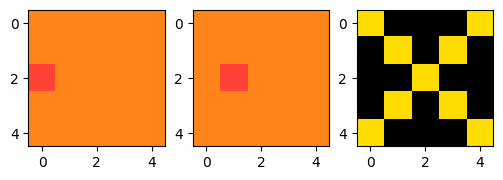

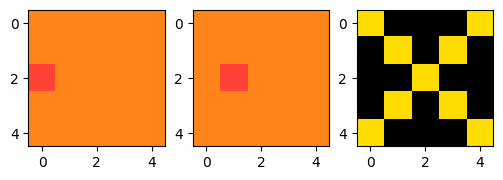

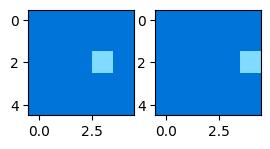

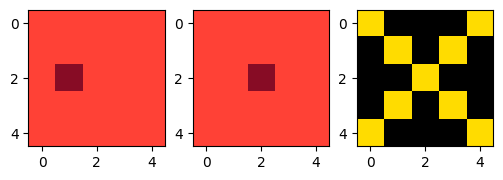

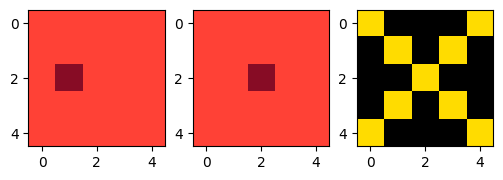

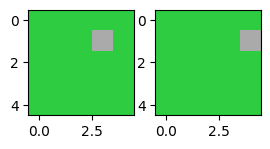

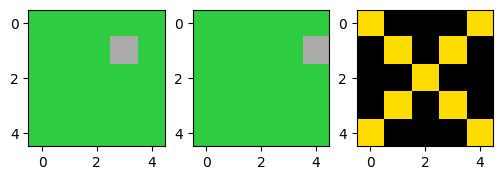

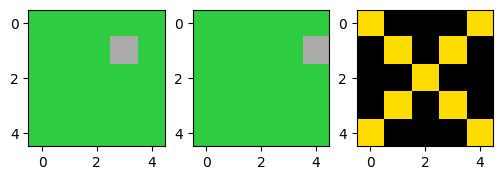

In [89]:
print (len(correct_idxs))
if len(correct_idxs) > 0:
  subset=[ correct_idxs[np.random.randint(0, len(correct_idxs))] for i in range(10) ]
  print(subset)
  solve_and_plot(transformer, training_set, subset)


## Plot Corresponding Test Tasks
These are the same training tasks with correct prediction in the Training set, but now we find those same tasks in the Test set.

In [90]:
crt = {}
for c in subset:
  task = training_set.names[c].split("_")[0]
  if task in crt:
    crt[task]+=1
  else:
    crt[task]=0
print(len(crt)) # 24 / 400 - 6%
print(crt)

10
{'moveapixelxone-5x5-multicolor-03b934b8a1': 0, 'moveapixelxone-5x5-multicolor-8a0ff1eef3': 0, 'moveapixelxone-5x5-multicolor-984b8d0486': 0, 'moveapixelxone-5x5-multicolor-07d5caa87e': 0, 'moveapixelxone-5x5-multicolor-cc81e52bea': 0, 'moveapixelxone-5x5-multicolor-1c1de016bd': 0, 'moveapixelxone-5x5-multicolor-54d4967a57': 0, 'moveapixelxone-5x5-multicolor-f8be8281af': 0, 'moveapixelxone-5x5-multicolor-65dc94d0dd': 0, 'moveapixelxone-5x5-multicolor-93cdd9f24a': 0}


Task index: 21, Input: moveapixelxone-5x5-multicolor-03b934b8a1_train_0|moveapixelxone-5x5-multicolor-03b934b8a1_test_0, Target: moveapixelxone-5x5-multicolor-03b934b8a1_train_0|moveapixelxone-5x5-multicolor-03b934b8a1_test_0
Result Elements: 3, Accurate: True, Shape: (3, 5, 5, 3), Stopped: True
Loss tf.Tensor(0.0010001566251969286, shape=(), dtype=float64)
Task index: 569, Input: moveapixelxone-5x5-multicolor-8a0ff1eef3_train_0|moveapixelxone-5x5-multicolor-8a0ff1eef3_test_0, Target: moveapixelxone-5x5-multicolor-8a0ff1eef3_train_0|moveapixelxone-5x5-multicolor-8a0ff1eef3_test_0
Result Elements: 3, Accurate: True, Shape: (3, 5, 5, 3), Stopped: True
Loss tf.Tensor(0.0006456610924762386, shape=(), dtype=float64)
Task index: 611, Input: moveapixelxone-5x5-multicolor-984b8d0486_train_0|moveapixelxone-5x5-multicolor-984b8d0486_test_0, Target: moveapixelxone-5x5-multicolor-984b8d0486_train_0|moveapixelxone-5x5-multicolor-984b8d0486_test_0
Result Elements: 3, Accurate: True, Shape: (3, 5, 5,

<ipython-input-87-77614daf4bfa>:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, len(pred), figsize = (6, 9))


Task index: 1027, Input: moveapixelxone-5x5-multicolor-f8be8281af_train_0|moveapixelxone-5x5-multicolor-f8be8281af_test_0, Target: moveapixelxone-5x5-multicolor-f8be8281af_train_0|moveapixelxone-5x5-multicolor-f8be8281af_test_0
Result Elements: 3, Accurate: True, Shape: (3, 5, 5, 3), Stopped: True
Loss tf.Tensor(0.0009725345864402737, shape=(), dtype=float64)
Task index: 435, Input: moveapixelxone-5x5-multicolor-65dc94d0dd_train_0|moveapixelxone-5x5-multicolor-65dc94d0dd_test_0, Target: moveapixelxone-5x5-multicolor-65dc94d0dd_train_0|moveapixelxone-5x5-multicolor-65dc94d0dd_test_0
Result Elements: 3, Accurate: False, Shape: (3, 5, 5, 3), Stopped: True
Loss tf.Tensor(0.0015325577241015694, shape=(), dtype=float64)
Task index: 594, Input: moveapixelxone-5x5-multicolor-93cdd9f24a_train_0|moveapixelxone-5x5-multicolor-93cdd9f24a_test_0, Target: moveapixelxone-5x5-multicolor-93cdd9f24a_train_0|moveapixelxone-5x5-multicolor-93cdd9f24a_test_0
Result Elements: 3, Accurate: False, Shape: (3, 5

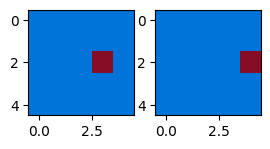

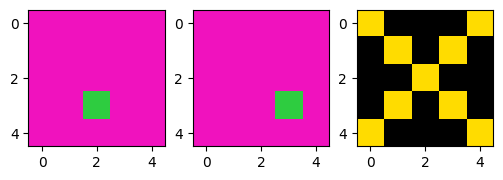

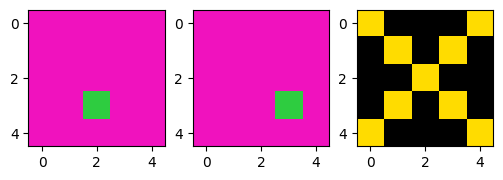

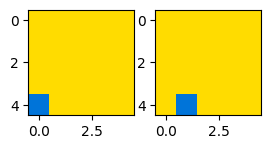

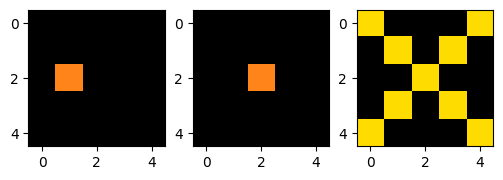

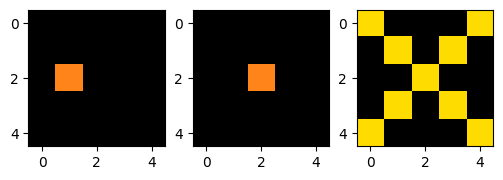

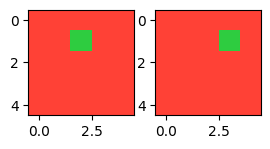

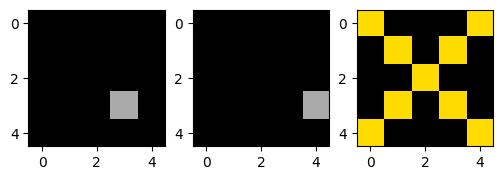

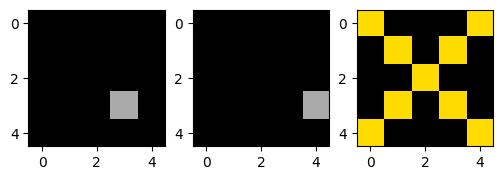

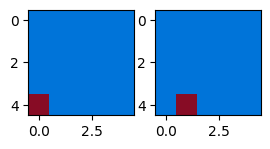

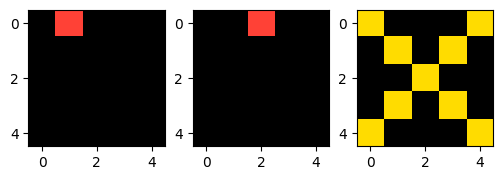

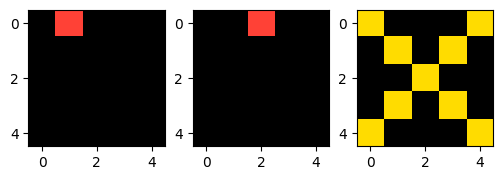

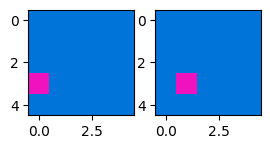

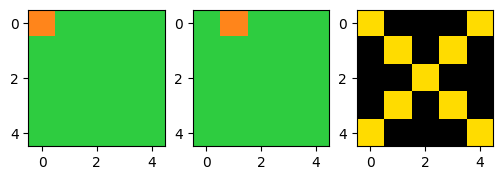

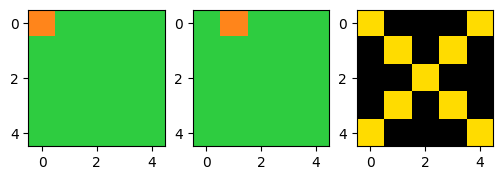

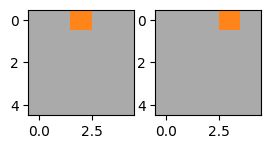

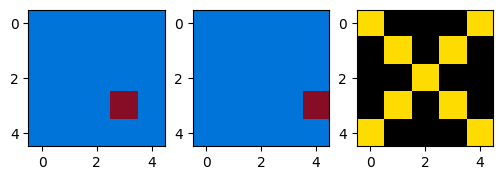

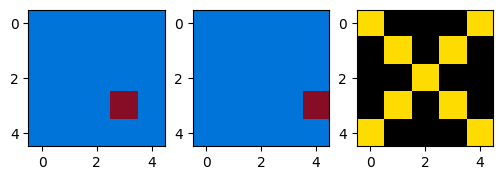

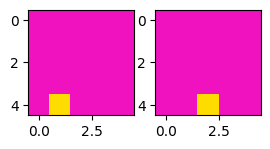

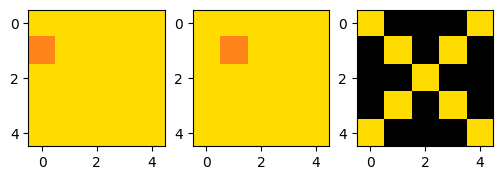

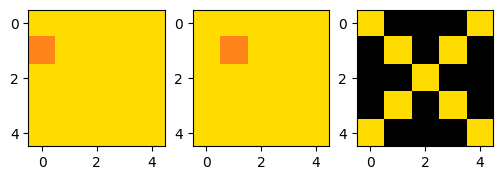

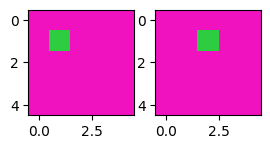

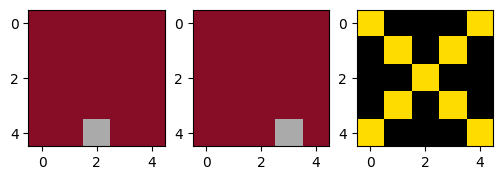

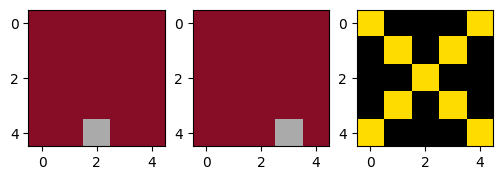

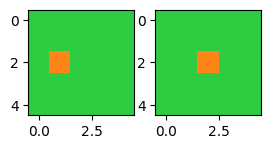

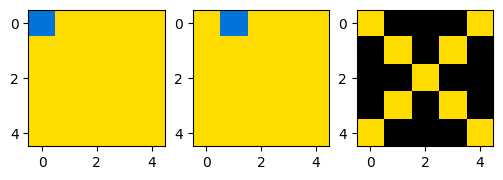

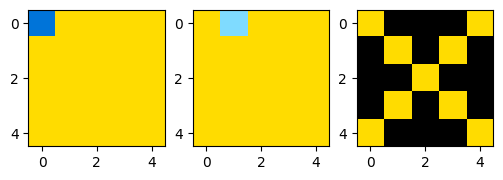

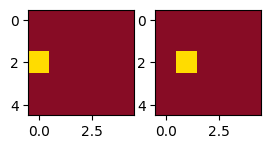

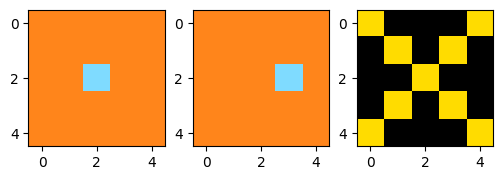

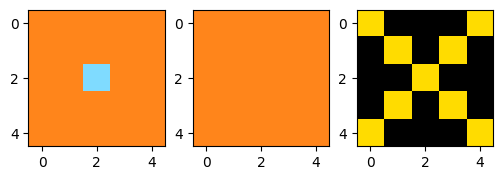

In [91]:
cases = [c+"_test_0" for c in crt.keys()]
inds = []
for c in cases:
    inds.append(next(i for i, s in enumerate(validatn_set.names) if s.endswith(c)))
solve_and_plot(transformer, validatn_set, inds)


## Plot Incorrect Train Tasks

520
[13, 14, 25, 26, 70, 71, 82, 83, 84, 85, 89, 98, 99, 110, 111, 122, 123, 128, 129, 134, 135, 148, 149, 193, 194, 199, 200, 201, 202, 251, 252, 257, 258, 302, 303, 322, 323, 326, 327, 344, 345, 364, 365, 371, 396, 397, 400, 401, 402, 426, 427, 436, 437, 438, 439, 453, 454, 455, 463, 464, 465, 518, 567, 568, 590, 621, 622, 645, 646, 681, 682, 718, 719, 772, 773, 774, 775, 777, 787, 788, 789, 793, 794, 805, 806, 829, 830, 841, 842, 843, 844, 876, 877, 880, 881, 914, 915, 917, 920, 921, 941, 942, 949, 950, 971, 972, 989, 993, 994, 1017, 1018, 1025, 1026, 1033, 1037, 1067, 1083, 1084, 1106, 1107, 1114, 1115, 1170, 1171, 1186, 1187, 1194, 1195, 1281, 1282, 1287, 1288, 1289, 1290, 1325, 1326, 1373, 1374, 1405, 1406, 1407, 1408, 1423, 1424, 1436, 1437, 1442, 1443, 1462, 1463, 1470, 1471, 1495, 1496, 1502, 1503, 1504, 1518, 1522, 1523, 1582, 1583, 1598, 1599, 1612, 1613, 1614, 1615, 1656, 1657, 1660, 1661, 1662, 1666, 1667, 1668, 1675, 1676, 1677, 1690, 1691, 1692, 1693, 1704, 1705, 1757, 1

<ipython-input-87-77614daf4bfa>:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, len(pred), figsize = (6, 9))


Task index: 4219, Input: moveapixelxone-5x5-multicolor-e5782eedeb_train_2|moveapixelxone-5x5-multicolor-e5782eedeb_train_1, Target: moveapixelxone-5x5-multicolor-e5782eedeb_train_2|moveapixelxone-5x5-multicolor-e5782eedeb_train_1
Result Elements: 3, Accurate: False, Shape: (3, 5, 5, 3), Stopped: True
Loss tf.Tensor(0.002713882986601519, shape=(), dtype=float64)
Task index: 1850, Input: moveapixelxone-5x5-multicolor-62a18ccc7b_train_2|moveapixelxone-5x5-multicolor-62a18ccc7b_train_2, Target: moveapixelxone-5x5-multicolor-62a18ccc7b_train_2|moveapixelxone-5x5-multicolor-62a18ccc7b_train_2
Result Elements: 3, Accurate: False, Shape: (3, 5, 5, 3), Stopped: True
Loss tf.Tensor(0.004960201639671416, shape=(), dtype=float64)
Task index: 3687, Input: moveapixelxone-5x5-multicolor-c422281794_train_1|moveapixelxone-5x5-multicolor-c422281794_train_1, Target: moveapixelxone-5x5-multicolor-c422281794_train_1|moveapixelxone-5x5-multicolor-c422281794_train_1
Result Elements: 3, Accurate: False, Shape

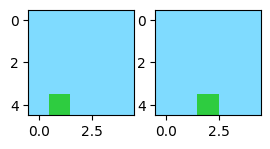

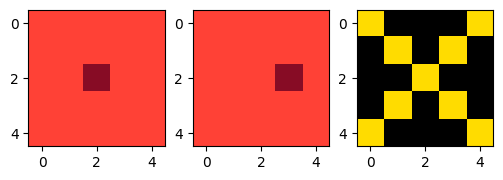

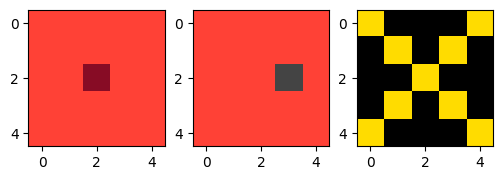

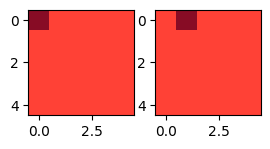

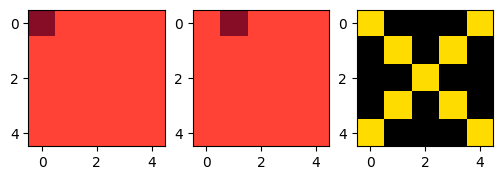

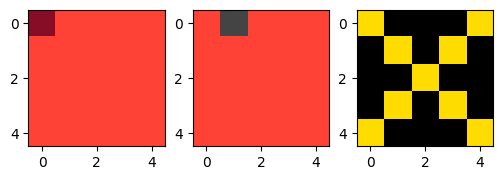

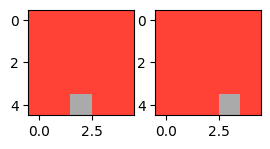

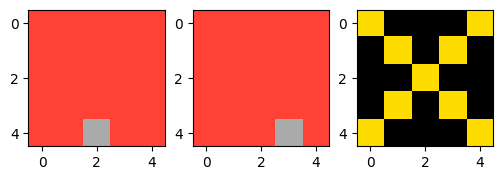

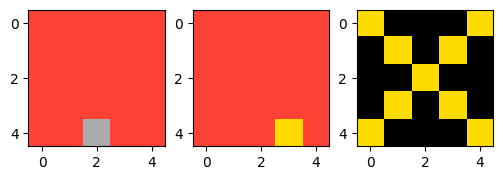

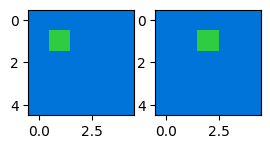

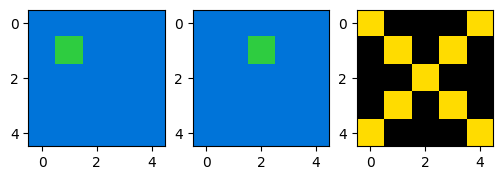

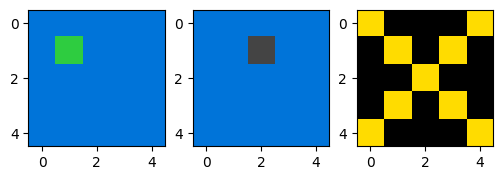

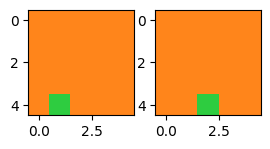

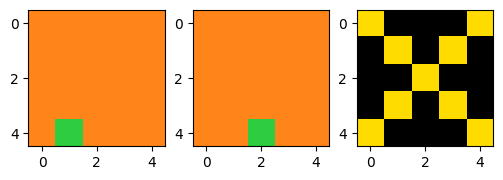

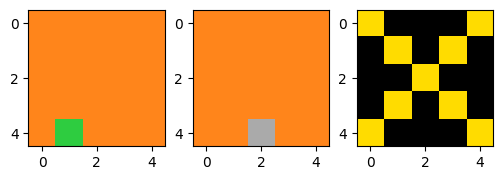

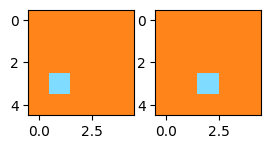

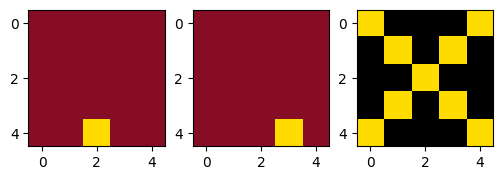

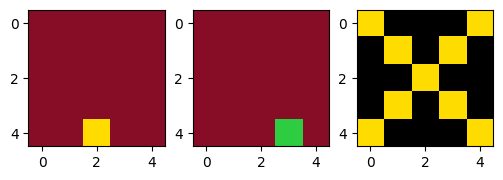

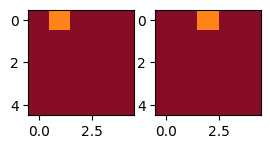

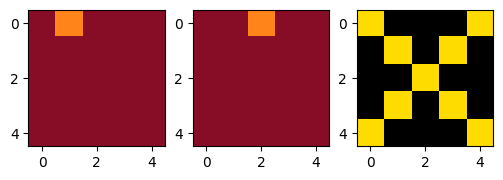

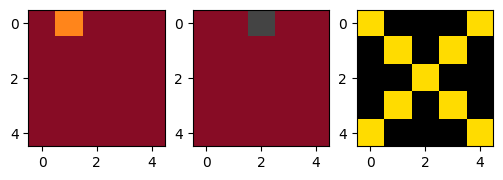

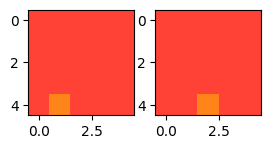

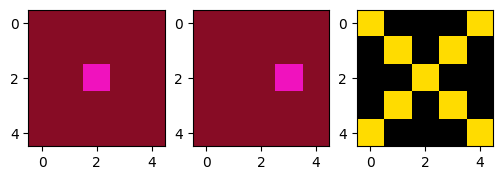

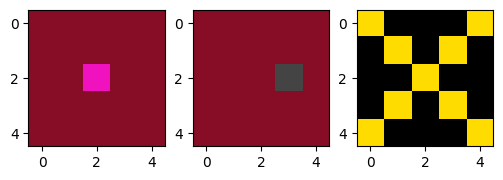

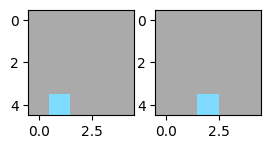

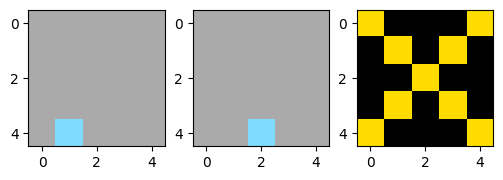

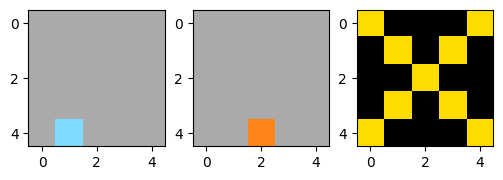

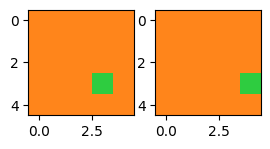

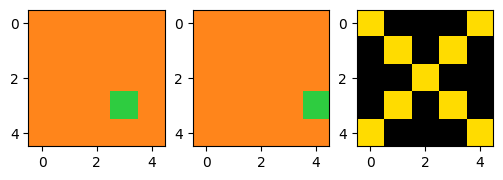

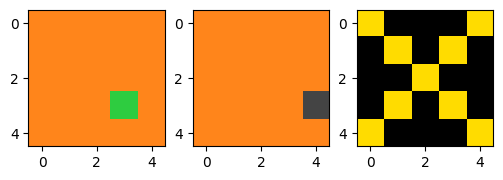

In [93]:
incorrect_idxs = [ x for x in range(len(training_set.names)) if x not in correct_idxs ]
print(len(incorrect_idxs))
print(incorrect_idxs)
if len(incorrect_idxs) > 0:
  if len(incorrect_idxs) > 10:
    subset=[ incorrect_idxs[np.random.randint(0, len(incorrect_idxs))] for i in range(10) ]
  else:
    subset=incorrect_idxs
  print(subset)
  solve_and_plot(transformer, training_set, subset)

## Random Pick from Training Set

Task index: 45, Input: moveapixelxone-5x5-multicolor-01c47be00b_train_2|moveapixelxone-5x5-multicolor-01c47be00b_train_2, Target: moveapixelxone-5x5-multicolor-01c47be00b_train_2|moveapixelxone-5x5-multicolor-01c47be00b_train_2
Result Elements: 3, Accurate: True, Shape: (3, 5, 5, 3), Stopped: True
Loss tf.Tensor(0.0006474679083232915, shape=(), dtype=float64)


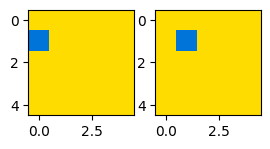

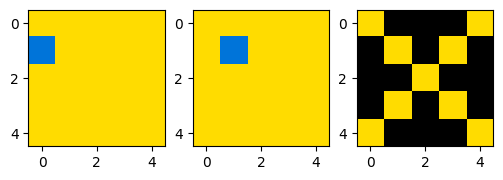

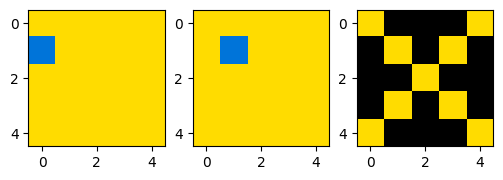

In [94]:
solve_and_plot(transformer, training_set)